In [1]:
cd /home/admin/projects/learn_miniai/

/home/admin/projects/learn_miniai


In [2]:
#| default_exp learner

In [3]:
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader, default_collate
from torch import tensor
import torchvision.transforms.functional as TF

from miniai.datasets import inplace
from miniai.datasets import show_images
from miniai.datasets import transforms
from miniai.datasets import DataLoaders
from miniai.training import get_dls
from miniai.training import to_device
from miniai.training import accuracy
from operator import attrgetter

from miniai.conv import conv
from torch import nn
from miniai.training import fit
from miniai.training import def_device
from torch import optim
from functools import partial
from collections.abc import Mapping

In [4]:
def_device

'cuda'

In [5]:
class Learner():
    def __init__(self, model, dls, loss_func, opt_func=optim.SGD, lr=0.1):
        self.model, self.dls, self.loss_func, self.opt_func, self.lr = model, dls, loss_func, opt_func, lr
        
    def one_batch(self):
        xb, yb = to_device(self.batch)
        pred = self.model(xb)
        loss = self.loss_func(pred, yb)
        acc = accuracy(pred, yb)
        if self.model.training:
            loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        self.losses.append(loss.item())
        self.accs.append(acc.item())
        
    def one_epoch(self, train):
        self.losses, self.accs = [], []
        self.model.training = train
        dl = self.dls.train if self.model.training else self.dls.val
        for self.i, self.batch in enumerate(dl):
            self.one_batch()
        print(f"Epoch: {self.epoch}: Loss {sum(self.losses) / len(self.losses):.2f}. Acc {sum(self.accs) / len(self.accs):.2f}")

    def fit(self, n_epoch):
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epoch
        for self.epoch in range(n_epoch):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)

In [6]:
name = 'fashion_mnist'
bs = 1024
dataset = load_dataset(name).with_transform(transforms)
dls = DataLoaders.from_dd(dataset, bs, num_workers=8)

Found cached dataset fashion_mnist (/home/admin/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
def get_model():
    return nn.Sequential(conv(1,4), #14x14
                          conv(4,8), #7x7
                          conv(8,32), #4x4
                          conv(32,32), #2x2
                          conv(32,10, act=False), #2x2
                          nn.Flatten()
                         )

In [8]:
model = get_model()

In [9]:
learner = Learner(model, dls, loss_func = nn.CrossEntropyLoss())

learner.fit(8)

Epoch: 0: Loss 2.30. Acc 0.10
Epoch: 0: Loss 2.30. Acc 0.10
Epoch: 1: Loss 2.30. Acc 0.12
Epoch: 1: Loss 2.29. Acc 0.19
Epoch: 2: Loss 2.20. Acc 0.24
Epoch: 2: Loss 1.56. Acc 0.53
Epoch: 3: Loss 1.15. Acc 0.59
Epoch: 3: Loss 1.01. Acc 0.60
Epoch: 4: Loss 0.84. Acc 0.69
Epoch: 4: Loss 0.80. Acc 0.70
Epoch: 5: Loss 0.74. Acc 0.72
Epoch: 5: Loss 0.73. Acc 0.73
Epoch: 6: Loss 0.70. Acc 0.74
Epoch: 6: Loss 0.71. Acc 0.73
Epoch: 7: Loss 0.66. Acc 0.75
Epoch: 7: Loss 0.64. Acc 0.77


## Add callback

In [10]:
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [11]:
import time

class Callback():
    order = 0

class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f"There are total {self.count} batches!")
    def __repr__(self): return f"CB.order_{self.order}. count {self.count}"

class TimeCB(Callback):
    def before_fit(self, learn): self.start_time = time.time()
    def after_fit(self, learn): print(f"Elapsed time: {time.time() - self.start_time:.04f} seconds")
    def __repr__(self): return f"CB.order_{self.order}"
    
class HighOrder(Callback):
    order = 10
#     def before_fit(self, learn): self.count = 0
#     def after_epoch(self, learn): self.count += 1
#     def after_fit(self, learn): print(f"There are total {self.count} epoch!")
    def __repr__(self): return f"CB.order_{self.order}"

In [12]:
cbs = [CompletionCB(), TimeCB()]
cbs.sort(key=lambda p: -p.order)

method_name, learn = 'before_fit', None
for cb in cbs:
    method = getattr(cb, method_name, None)
    if method is not None: method(learn)
    print(cb)
    
method_name, learn = 'after_batch', None
for cb in cbs:
    method = getattr(cb, method_name, None)
    if method is not None: method(learn)
    print(cb)
    
method_name, learn = 'after_fit', None
for cb in cbs:
    method = getattr(cb, method_name, None)
    if method is not None: method(learn)
    print(cb)

CB.order_0. count 0
CB.order_0
CB.order_0. count 1
CB.order_0
There are total 1 batches!
CB.order_0. count 1
Elapsed time: 0.0001 seconds
CB.order_0


In [13]:
def run_cbs(cbs, method_name, learn=None):
    cbs.sort(key=lambda p: p.order)
    for cb in cbs:
        method = getattr(cb, method_name, None)
        if method is not None: method(learn)

In [14]:
class OneBatchCB(Callback):
    order = 10
    def after_batch(self, learn): raise CancelFitException
        
    def __repr__(self): return f"CB.order_{self.order}"

In [15]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit', learn=None)
run_cbs(cbs, 'after_batch', learn=None)
run_cbs(cbs, 'after_batch', learn=None)
run_cbs(cbs, 'after_batch', learn=None)
run_cbs(cbs, 'after_fit', learn=None)

There are total 3 batches!


In [16]:
class Learner():
    def __init__(self, model, dls, loss_func, cbs=[], opt_func=optim.SGD, lr=0.1):
        self.model, self.dls, self.loss_func, self.cbs, self.opt_func, self.lr = model, dls, loss_func, cbs, opt_func, lr
        
    def one_batch(self):
        try:
            self.callback('before_batch')
            self.xb, self.yb = self.batch
            self.pred = self.model(self.xb)
            self.loss = self.loss_func(self.pred, self.yb)
            if self.model.training:
                self.loss.backward()
                self.opt.step()
                self.opt.zero_grad()
            self.callback('after_batch')
        except CancelBatchException: pass

    def one_epoch(self, train):
        self.losses, self.accs = [], []
        self.model.training = train
        dl = self.dls.train if self.model.training else self.dls.val
        try:
            self.callback('before_epoch')
            for self.i, self.batch in enumerate(dl):
                self.one_batch()
            self.callback('after_epoch')
        except CancelEpochException: pass

    def fit(self, n_epoch):
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epoch
        try:
            self.callback('before_fit')
            for self.epoch in range(n_epoch):
                self.one_epoch(True)
                with torch.no_grad(): self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass
        
    def callback(self, method_name): run_cbs(self.cbs, method_name, self)
        
    @property
    def training(self): return self.model.training

In [17]:
_ = model.to('cpu')

In [18]:
learner = Learner(model, dls, cbs = [OneBatchCB()], loss_func = nn.CrossEntropyLoss())

learner.fit(1)

In [19]:
learner = Learner(model, dls, cbs = [CompletionCB(), TimeCB()], loss_func = nn.CrossEntropyLoss())

learner.fit(1)

There are total 64 batches!
Elapsed time: 2.4892 seconds


## Metric

In [20]:
class Metric():
    def __init__(self):
        self.ns, self.vs = [], []
    
    def reset(self): self.ns, self.vs = [], []

    def add(self, x, targs=None, n=1):
        last = self.calc(x, targs)
        self.ns.append(n)
        self.vs.append(last)
    
    @property
    def value(self):
        return sum(self.vs)/sum(self.ns)
    
    def calc(self, x, y):
        return x

metric = Metric()

metric.add(3)
metric.add(4)
metric.value

3.5

In [21]:
class Accuracy(Metric):
    def calc(self, pred, yb):
        return (pred.argmax(1) == yb).float().mean()
    
class Loss(Metric):
    def calc(self, x, yb):
        return x

In [22]:
def to_cpu(x):
    if isinstance(x, torch.Tensor): return x.to('cpu')
    if isinstance(x, Mapping): return {k: v.to('cpu') for k,v in x.items()}
    return type(x)(o.to('cpu') for o in x)

In [23]:
xb, yb = next(iter(dls.train))

model.to('cpu')
pred = model(xb)

In [24]:
acc = Accuracy()
acc.add(pred, yb)
acc.value

tensor(0.8086)

In [25]:
loss = Loss()
loss.add(3, None)
loss.value

3.0

In [26]:
class MatrixCB(Callback):
    acc, loss = Accuracy(), Loss()
    def after_batch(self, learn):
        self.acc.add(learn.pred, learn.yb)
        self.loss.add(learn.loss)
        
    def after_epoch(self, learn):
        print(self)
        self.reset()
        
    def reset(self):
        self.acc.reset()
        self.loss.reset()

    def __repr__(self): return f"acc {self.acc.value}, loss {self.loss.value}"

In [27]:
model.to('cpu')
learner = Learner(model, dls, cbs = [MatrixCB(), TimeCB()], loss_func = nn.CrossEntropyLoss())

learner.fit(1)

acc 0.7796923518180847, loss 0.5916836857795715
acc 0.7497260570526123, loss 0.6467958688735962
Elapsed time: 2.4914 seconds


In [28]:
class DeviceCB(Callback):
    
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(def_device)
    
    def before_batch(self, learn):
        learn.batch = to_device(learn.batch)

In [29]:
learner = Learner(model, dls, cbs = [MatrixCB(), TimeCB(), DeviceCB()], loss_func = nn.CrossEntropyLoss())

learner.fit(1)

acc 0.7899885773658752, loss 0.5681154131889343
acc 0.7894038558006287, loss 0.5770344138145447
Elapsed time: 2.3563 seconds


In [30]:
# pip install torcheval

In [31]:
import torch
from torcheval.metrics import MulticlassAccuracy, Mean
metric = MulticlassAccuracy()
input = torch.tensor([0, 2, 1, 3])
target = torch.tensor([0, 1, 1, 3])
metric.update(input, target)
metric.compute()

tensor(0.7500)

In [32]:
class MatrixCB(Callback):
    acc, loss = MulticlassAccuracy(), Mean()
    def after_batch(self, learn):
        self.acc.update(to_cpu(learn.pred), to_cpu(learn.yb.to('cpu')))
        self.loss.update(to_cpu(learn.loss))
        
    def after_epoch(self, learn):
        print(self)
        self.reset()
        
    def reset(self):
        self.acc.reset()
        self.loss.reset()

    def __repr__(self): return f"acc {self.acc.compute()}, loss {self.loss.compute()}"

In [33]:
learner = Learner(model, dls, cbs = [MatrixCB(), TimeCB(), DeviceCB()], loss_func = nn.CrossEntropyLoss())
learner.fit(1)

acc 0.7980333566665649, loss 0.5465482402656038
acc 0.7853000164031982, loss 0.5690273880958557
Elapsed time: 2.3862 seconds


In [34]:
from copy import copy

class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
    
    def before_fit(self, learn): learn.metrics = self
        
    def after_batch(self, learn):
        for v in self.metrics.values():
            v.update(to_cpu(learn.pred), to_cpu(learn.yb.to('cpu')))
        self.loss.update(to_cpu(learn.loss))
        
    def before_epoch(self, learn):
        for v in self.all_metrics.values(): v.reset()
        
    def _log(self, log):
        print(log)
        
    def after_epoch(self, learn):
        log = {k:f"{v.compute().item():.2f}" for k, v in self.all_metrics.items()}
        log['train'] = learn.model.training
        log['epoch'] = learn.epoch
        self._log(log)
    
    def reset(self):
        for v in self.matrics.values():
            v.reset()
        self.loss.reset()

In [35]:
metrics = MetricsCB(acc=MulticlassAccuracy())

learner = Learner(get_model(), dls, cbs = [metrics, TimeCB(), DeviceCB()], loss_func = nn.CrossEntropyLoss())
learner.fit(3)

{'acc': '0.11', 'loss': '2.30', 'train': True, 'epoch': 0}
{'acc': '0.25', 'loss': '2.30', 'train': False, 'epoch': 0}
{'acc': '0.30', 'loss': '2.29', 'train': True, 'epoch': 1}
{'acc': '0.30', 'loss': '2.25', 'train': False, 'epoch': 1}
{'acc': '0.48', 'loss': '1.56', 'train': True, 'epoch': 2}
{'acc': '0.61', 'loss': '1.01', 'train': False, 'epoch': 2}
Elapsed time: 7.0845 seconds


### Context

In [36]:
from contextlib import contextmanager

@contextmanager
def print_out(a):
    print(f'before {a.value}')
    yield
    print(f'after {a.value}')
    
class Variable():
    def __init__(self, x):
        self.value = x
        
    def add(self, n):
        self.value += n

x = Variable(23)

with print_out(x):
    x.add(3)
    print(x.value)

before 23
26
after 26


In [37]:
class with_cbs():
    def __init__(self, nm):
        self.nm = nm
        self.train = 1
        self.val = 1

    def __call__(self, func):
        def wrapper(o, *args, **kwargs):
            try:
                o.callback(f"before_{self.nm}")
            
                func(o, *args, **kwargs)
            except globals()[f'Cancel{self.nm.title()}Exception']:
                pass
            finally: o.callback(f"after_{self.nm}")
        return wrapper

class Learner():
    def __init__(self, model, dls, cbs=[], loss_func=nn.CrossEntropyLoss(), opt_func=optim.SGD, lr=0.1):
        self.model, self.dls, self.loss_func, self.cbs, self.opt_func, self.lr = model, dls, loss_func, cbs, opt_func, lr
    
    @with_cbs('batch')
    def one_batch(self):
        self.xb, self.yb = self.batch
        self.predict()
        self.get_loss()
        if self.model.training:
            self.backward()
            self.step()
            self.zero_grad()
    
    @with_cbs('epoch')
    def _one_epoch(self):
        for self.i, self.batch in enumerate(self.dl):
            self.one_batch()

    def one_epoch(self, train):
        self.losses, self.accs = [], []
        self.model.training = train
        self.dl = self.dls.train if self.model.training else self.dls.val
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train=1, val=1):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if val:
                with torch.no_grad(): self.one_epoch(False)
    
    def fit(self, n_epochs, train=1, val=1):
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self._fit(train, val)
        
    def callback(self, method_name): run_cbs(self.cbs, method_name, self)
        
    @property
    def training(self): return self.model.training
    
    def __getattr__(self, attr):
        if attr in ['predict', 'get_loss', 'backward', 'step', 'zero_grad']:
            return partial(self.callback, attr)
        else: AttributeError(attr)

In [57]:
class TrainCB(Callback):
    def predict(self): self.pred = self.model(self.xb)
    def get_loss(self): self.loss = self.loss_func(self.pred, self.yb)
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [58]:
class TrainLearner(Learner):
    def predict(self): self.pred = self.model(self.xb)
    def get_loss(self): self.loss = self.loss_func(self.pred, self.yb)
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [39]:
from fastprogress import progress_bar, master_bar
import fastcore.all as fc

class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot

    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)

    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

acc,loss,train,epoch
0.13,2.30,True,0
0.18,2.30,False,0
0.24,2.30,True,1
0.35,2.29,False,1
0.35,2.10,True,2
0.56,1.26,False,2


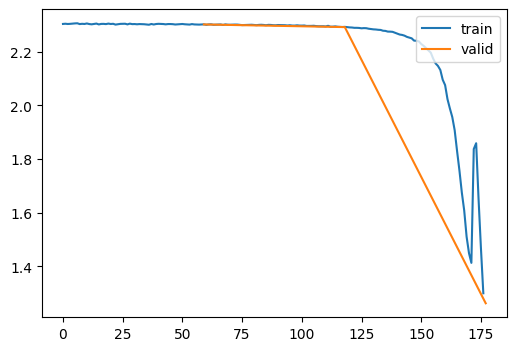

Elapsed time: 13.9948 seconds


In [40]:
metrics = MetricsCB(acc=MulticlassAccuracy())
cbs = [metrics, TimeCB(), DeviceCB(), ProgressCB(plot=True)]
learner = TrainLearner(get_model(), dls, cbs=cbs)
learner.fit(3, 1, 1)

In [41]:
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, cbs=None, loss_func=nn.CrossEntropyLoss(), lr=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, cbs, loss_func, opt_func, lr)
# def __init__(self, model, dls, cbs=[], loss_func=nn.CrossEntropyLoss(), opt_func=optim.SGD, lr=0.1):
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

acc,loss,train,epoch
0.33,2.02,True,0
0.67,0.96,False,0
0.75,0.67,True,1
0.78,0.59,False,1
0.81,0.52,True,2
0.81,0.52,False,2


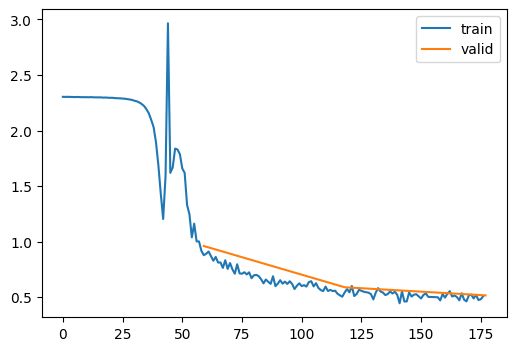

Elapsed time: 13.6155 seconds


In [42]:
metrics = MetricsCB(acc=MulticlassAccuracy())
cbs = [metrics, TimeCB(), DeviceCB(), ProgressCB(plot=True)]
learner = MomentumLearner(get_model(), dls, cbs=cbs, lr=0.1)
learner.fit(3, 1, 1)

### LRfinder

In [55]:
import math
from matplotlib import pyplot as plt

class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.1):
        self.lr_mult = lr_mult
        self.i = 0
        
    def before_fit(self, learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf
        
    def after_batch(self, learn):
        self.i += 1
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss.item())
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult
                
    def after_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

{'acc': '0.12', 'loss': '2.30', 'train': True, 'epoch': 0}
{'acc': '0.11', 'loss': '2.30', 'train': False, 'epoch': 0}
{'acc': '0.12', 'loss': '2.29', 'train': True, 'epoch': 1}
{'acc': '0.30', 'loss': '2.13', 'train': False, 'epoch': 1}
Elapsed time: 4.6400 seconds


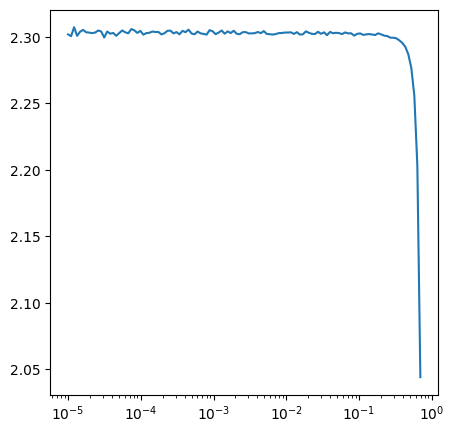

In [56]:
metrics = MetricsCB(acc=MulticlassAccuracy())
lr_finder = LRFinderCB()
cbs = [metrics, TimeCB(), DeviceCB(), lr_finder]
learner = MomentumLearner(get_model(), dls, cbs=cbs, lr=1e-5)
learner.fit(2)

In [50]:
metrics = MetricsCB(acc=MulticlassAccuracy())
cbs = [metrics, TimeCB(), DeviceCB()]
learner = MomentumLearner(get_model(), dls, cbs=cbs, lr=0.1)
learner.fit(3)

{'acc': '0.13', 'loss': '2.28', 'train': True, 'epoch': 0}
{'acc': '0.38', 'loss': '1.80', 'train': False, 'epoch': 0}
{'acc': '0.16', 'loss': '2.26', 'train': True, 'epoch': 1}
{'acc': '0.36', 'loss': '1.64', 'train': False, 'epoch': 1}
{'acc': '0.49', 'loss': '1.48', 'train': True, 'epoch': 2}
{'acc': '0.69', 'loss': '0.83', 'train': False, 'epoch': 2}
Elapsed time: 7.1548 seconds
